In [26]:
import imp
import time
import argparse
import numpy as np
import torch
torch.set_printoptions(threshold=10000)
from torch_geometric.datasets import Planetoid,Reddit2,Flickr
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
# from torch_geometric.loader import DataLoader
from help_funcs import prune_unrelated_edge,prune_unrelated_edge_isolated, clu_prune_unrelated_edge
import scipy.sparse as sp
from torch_geometric.utils import subgraph
# Training settings
parser = argparse.ArgumentParser()
parser.add_argument('--debug', action='store_true',
        default=True, help='debug mode')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='Disables CUDA training.')
parser.add_argument('--seed', type=int, default=12, help='Random seed.')
parser.add_argument('--model', type=str, default='GCN', help='model',
                    choices=['GCN','GAT','GraphSage','GIN'])
parser.add_argument('--dataset', type=str, default='Pubmed', 
                    help='Dataset',
                    choices=['Cora','Pubmed','Flickr','ogbn-arxiv','Citeseer','Reddit2'])
parser.add_argument('--train_lr', type=float, default=0.01,
                    help='Initial learning rate.')
parser.add_argument('--weight_decay', type=float, default=5e-4,
                    help='Weight decay (L2 loss on parameters).')
parser.add_argument('--hidden', type=int, default=128,
                    help='Number of hidden units.')
parser.add_argument('--thrd', type=float, default=0.5)
parser.add_argument('--target_class', type=int, default=2)
parser.add_argument('--k', type=int, default=100)
parser.add_argument('--dropout', type=float, default=0.5,
                    help='Dropout rate (1 - keep probability).')
parser.add_argument('--epochs', type=int,  default=1000, help='Number of epochs to train benign and backdoor model.')
parser.add_argument('--rec_epochs', type=int,  default=30, help='Number of epochs to train benign and backdoor model.')
parser.add_argument('--trojan_epochs', type=int,  default=400, help='Number of epochs to train trigger generator.')
parser.add_argument('--inner', type=int,  default=1, help='Number of inner')
# backdoor setting
parser.add_argument('--lr', type=float, default=0.01,
                    help='Initial learning rate.')
parser.add_argument('--trigger_size', type=int, default=3,
                    help='tirgger_size')
parser.add_argument('--use_vs_number', action='store_true', default=True,
                    help="if use detailed number to decide Vs")
parser.add_argument('--vs_ratio', type=float, default=0,
                    help="ratio of poisoning nodes relative to the full graph")
parser.add_argument('--range', type=float, default=1.0,
                    help="ratio of poisoning nodes relative to the full graph")
parser.add_argument('--vs_number', type=int, default=160,
                    help="number of poisoning nodes relative to the full graph")
# defense setting
parser.add_argument('--defense_mode', type=str, default="none",
                    choices=['prune', 'isolate', 'none','reconstruct'],
                    help="Mode of defense")
parser.add_argument('--prune_thr', type=float, default=0.8,
                    help="Threshold of prunning edges")
parser.add_argument('--target_loss_weight', type=float, default=1,
                    help="Weight of optimize outter trigger generator")
parser.add_argument('--weight_target', type=float, default=1,
                    help="Weight of optimize outter trigger generator")
parser.add_argument('--weight_ood', type=float, default=1,
                    help="Weight of optimize outter trigger generator")
parser.add_argument('--weight_targetclass', type=float, default=1,
                    help="Weight of optimize outter trigger generator")
parser.add_argument('--outter_size', type=int, default=4096,
                    help="Weight of optimize outter trigger generator")
parser.add_argument('--homo_loss_weight', type=float, default=100,
                    help="Weight of optimize similarity loss")
parser.add_argument('--homo_boost_thrd', type=float, default=0.8,
                    help="Threshold of increase similarity")
# attack setting
parser.add_argument('--dis_weight', type=float, default=1,
                    help="Weight of cluster distance")
parser.add_argument('--selection_method', type=str, default='none',
                    choices=['loss','conf','cluster','none','cluster_degree'],
                    help='Method to select idx_attach for training trojan model (none means randomly select)')
parser.add_argument('--test_model', type=str, default='GCN',
                    choices=['GCN','GAT','GraphSage','GIN'],
                    help='Model used to attack')
parser.add_argument('--evaluate_mode', type=str, default='1by1',
                    choices=['overall','1by1'],
                    help='Model used to attack')
# GPU setting
parser.add_argument('--device_id', type=int, default=2,
                    help="Threshold of prunning edges")
# args = parser.parse_args()
args = parser.parse_known_args()[0]
args.cuda =  not args.no_cuda and torch.cuda.is_available()
device = torch.device(('cuda:{}' if torch.cuda.is_available() else 'cpu').format(args.device_id))

np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
print(args)

Namespace(cuda=True, dataset='Pubmed', debug=True, defense_mode='none', device_id=2, dis_weight=1, dropout=0.5, epochs=1000, evaluate_mode='1by1', hidden=128, homo_boost_thrd=0.8, homo_loss_weight=100, inner=1, k=100, lr=0.01, model='GCN', no_cuda=False, outter_size=4096, prune_thr=0.8, range=1.0, rec_epochs=30, seed=12, selection_method='none', target_class=2, target_loss_weight=1, test_model='GCN', thrd=0.5, train_lr=0.01, trigger_size=3, trojan_epochs=400, use_vs_number=True, vs_number=160, vs_ratio=0, weight_decay=0.0005, weight_ood=1, weight_target=1, weight_targetclass=1)


In [27]:
from torch_geometric.utils import to_undirected
import torch_geometric.transforms as T
transform = T.Compose([T.NormalizeFeatures()])

if(args.dataset == 'Cora' or args.dataset == 'Citeseer' or args.dataset == 'Pubmed'):
    dataset = Planetoid(root='./data/', \
                        name=args.dataset,\
                        transform=transform)
elif(args.dataset == 'Flickr'):
    dataset = Flickr(root='./data/Flickr/', \
                    transform=transform)
elif(args.dataset == 'Reddit2'):
    dataset = Reddit2(root='./data/Reddit2/', \
                    transform=transform)
elif(args.dataset == 'ogbn-arxiv'):
    from ogb.nodeproppred import PygNodePropPredDataset
    # Download and process data at './dataset/ogbg_molhiv/'
    dataset = PygNodePropPredDataset(name = 'ogbn-arxiv', root='./data/')
    split_idx = dataset.get_idx_split() 

data = dataset[0].to(device)

if(args.dataset == 'ogbn-arxiv'):
    nNode = data.x.shape[0]
    setattr(data,'train_mask',torch.zeros(nNode, dtype=torch.bool).to(device))
    # dataset[0].train_mask = torch.zeros(nEdge, dtype=torch.bool).to(device)
    data.val_mask = torch.zeros(nNode, dtype=torch.bool).to(device)
    data.test_mask = torch.zeros(nNode, dtype=torch.bool).to(device)
    data.y = data.y.squeeze(1)
    
if(args.dataset == 'Reddit2'):
    num_nodes_to_sample = 20000  # Adjust this based on your needs

    # Randomly select a subset of nodes
    sampled_nodes = torch.randint(data.num_nodes, (num_nodes_to_sample,), device=device)

    # Perform subgraph sampling
    edge,_ = subgraph(sampled_nodes, data.edge_index)
    data.edge_index = edge

In [28]:
from utils import get_split
data, idx_train, idx_val, idx_clean_test, idx_atk = get_split(args,data,device)

from torch_geometric.utils import to_undirected
from utils import subgraph
data.edge_index = to_undirected(data.edge_index)
train_edge_index,_, edge_mask = subgraph(torch.bitwise_not(data.test_mask),data.edge_index,relabel_nodes=False)
mask_edge_index = data.edge_index[:,torch.bitwise_not(edge_mask)]

In [29]:
from sklearn_extra import cluster
from models.backdoor import Backdoor
from models.construct import model_construct
import heuristic_selection as hs
from torch.distributions.bernoulli import Bernoulli

# select poisoned target node #

# filter out the unlabeled nodes except from training nodes and testing nodes, nonzero() is to get index, flatten is to get 1-d tensor
unlabeled_idx = (torch.bitwise_not(data.test_mask)&torch.bitwise_not(data.train_mask)).nonzero().flatten()
if(args.use_vs_number):
    size = args.vs_number
else:
    size = int((len(data.test_mask)-data.test_mask.sum())*args.vs_ratio)
# print("#Attach Nodes:{}".format(size))
assert size>0, 'The number of selected trigger nodes must be larger than 0!'
# here is randomly select poison nodes from unlabeled nodes
if(args.selection_method == 'none'):
    idx_attach = hs.obtain_attach_nodes(args,unlabeled_idx,size)
elif(args.selection_method == 'cluster'):
    idx_attach = hs.cluster_distance_selection(args,data,idx_train,idx_val,idx_clean_test,unlabeled_idx,train_edge_index,size,device)
    idx_attach = torch.LongTensor(idx_attach).to(device)
elif(args.selection_method == 'cluster_degree'):
    if(args.dataset == 'Pubmed'):
        idx_attach = hs.cluster_degree_selection_seperate_fixed(args,data,idx_train,idx_val,idx_clean_test,unlabeled_idx,train_edge_index,size,device)
    else:
        idx_attach = hs.cluster_degree_selection(args,data,idx_train,idx_val,idx_clean_test,unlabeled_idx,train_edge_index,size,device)
    idx_attach = torch.LongTensor(idx_attach).to(device)
# print("idx_attach: {}".format(idx_attach))
unlabeled_idx = torch.tensor(list(set(unlabeled_idx.cpu().numpy()) - set(idx_attach.cpu().numpy()))).to(device)
print('number of benign training nodes', len(idx_train))
print('number of poisoned target nodes', len(idx_attach))

# Cora
# idx_attach = torch.tensor([1672, 2399, 1785, 2020, 2013, 1652,  208, 1220, 2128,  446])
# Flicker
idx_attach = torch.tensor([ 2407, 14892, 10532, 11865, 10343,  4477,  6124, 13501, 16064, 16288,
        13241, 19092,  3261,  1473,   773,  4570,   744, 19660,    41, 17647,
         2590, 16881,  3837, 13691,  8013,  9920,   636,  4780, 13109, 13351,
        10086,  4145,  8146, 11758,  3936, 18992,  5991,  8038, 18082, 16778,
        14764, 18516, 18624,  2659, 11568,  6363, 17628,  7541, 17529,  8857,
        15031,   387, 15655, 18300, 11006,     1, 18977,  6870,  4800,  9171,
         2752,  3509,  9451,  5994, 10639,  8514, 13852, 15909, 15383, 18961,
         3241, 11481, 12033, 13359,  6130,  8003,  7938,  9119, 16206,  7469,
          512, 12784,  9765,  3562,  6826,  6278, 13067,   247,  2562, 13399,
         7239, 14831,  8724,  8416,  4572,  7645, 12721, 16473,  7433,  9726,
         3245, 16527, 19033,  6070, 11668,  7818, 14003, 15038,  4301,  8838,
        18121,   823,  6874,  7616, 11089,  8844,  7886, 17175,  7113,  7481,
         2625,   449, 10371,  1772, 15689,  4812,  7556, 12247, 17101,  9577,
        11005,  9181,   183,  4061, 11633, 14199, 16526,  7711,  6759, 18305,
         4873,   683, 18104,  7229, 12772, 10363, 15239,  8594, 16058,  5771,
        13088, 15769, 15966,   885,  5873,  8670, 15267,  9813,  3823, 17756])

idx_attach = idx_attach.to(device)

number of benign training nodes 3943
number of poisoned target nodes 160


In [30]:
## trigger generator ##
model = Backdoor(args,device)
model.fit(data.x, train_edge_index, None, data.y, idx_train,idx_attach, unlabeled_idx, True)

0

In [31]:
test_model = 'GCN'
total_overall_asr = 0
total_overall_ca = 0
args.test_model = test_model
rs = np.random.RandomState(args.seed)
seeds = rs.randint(1000,size=1)
overall_asr = 0
overall_ca = 0

In [32]:
# load poisoned graph #
# poison_x = torch.load('poison_x.pt')
# poison_edge_index = torch.load('poison_edge_index.pt')
# poison_edge_weights = torch.load('poison_edge_weights.pt')
# poison_labels = torch.load('poison_labels.pt')
poison_x = torch.load('./UGBA/poison_x_pubmed.pt')
poison_edge_index = torch.load('./UGBA/poison_edge_index_pubmed.pt')
poison_edge_weights = torch.load('./UGBA/poison_edge_weights_pubmed.pt')
poison_labels = torch.load('./UGBA/poison_labels_pubmed.pt')
# poison_x = torch.load('/home/zbz5349/defense_backdoor/DPGBA/kdd-backdooor/run_arxiv/poison_x.pt')
# poison_edge_index = torch.load('/home/zbz5349/defense_backdoor/DPGBA/kdd-backdooor/run_arxiv/poison_edge_index.pt')
# poison_edge_weights = torch.load('/home/zbz5349/defense_backdoor/DPGBA/kdd-backdooor/run_arxiv/poison_edge_weights.pt')
# poison_labels = torch.load('/home/zbz5349/defense_backdoor/DPGBA/kdd-backdooor/run_arxiv/poison_labels.pt')

In [33]:
print(args)

mask = data.y[idx_attach] != args.target_class
mask = mask.to(device)

## only attack those has groud truth labels != target_class ##
idx_attach = idx_attach[(data.y[idx_attach] != args.target_class).nonzero().flatten()]

bkd_tn_nodes = torch.cat([idx_train,idx_attach]).to(device)
# test_model = model_construct(args,args.test_model,data,device).to(device) 
known_nodes = torch.cat([idx_train,idx_attach]).to(device)
predictions = []
# edge weight for clean edge_index, may use later #
edge_weight = torch.ones([data.edge_index.shape[1]],device=device,dtype=torch.float)


Namespace(cuda=True, dataset='Pubmed', debug=True, defense_mode='none', device_id=2, dis_weight=1, dropout=0.5, epochs=1000, evaluate_mode='1by1', hidden=128, homo_boost_thrd=0.8, homo_loss_weight=100, inner=1, k=100, lr=0.01, model='GCN', no_cuda=False, outter_size=4096, prune_thr=0.8, range=1.0, rec_epochs=30, seed=12, selection_method='none', target_class=2, target_loss_weight=1, test_model='GCN', thrd=0.5, train_lr=0.01, trigger_size=3, trojan_epochs=400, use_vs_number=True, vs_number=160, vs_ratio=0, weight_decay=0.0005, weight_ood=1, weight_target=1, weight_targetclass=1)


In [34]:
mask.sum()

tensor(97, device='cuda:2')

In [35]:
print(data.y[idx_attach])
# idx_attach is selected target node #
print(poison_labels[idx_attach])

tensor([1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
        0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0,
        0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1,
        0], device='cuda:2')
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2], device='cuda:2')


In [36]:
test_model = model_construct(args,args.test_model,data,device).to(device) 
test_model.fit(poison_x,poison_edge_index, poison_edge_weights, poison_labels, bkd_tn_nodes, idx_val,train_iters=args.epochs,verbose=False)
test_model.eval()
clean_acc = test_model.test(poison_x,poison_edge_index, poison_edge_weights,poison_labels,idx_attach)
output_clean, x = test_model(poison_x,poison_edge_index,poison_edge_weights)
ori_predict = torch.exp(output_clean[known_nodes])
print("accuracy on poisoned target nodes: {:.4f}".format(clean_acc))

accuracy on poisoned target nodes: 1.0000


In [37]:
output_clean[idx_attach].argmax(dim=1)

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2], device='cuda:2')

In [38]:
# test backdoored model for comparison #
induct_edge_index = torch.cat([poison_edge_index,mask_edge_index],dim=1)
induct_edge_weights = torch.cat([poison_edge_weights,torch.ones([mask_edge_index.shape[1]],dtype=torch.float,device=device)])
induct_x, induct_edge_index,induct_edge_weights = model.inject_trigger(idx_atk,poison_x,induct_edge_index,induct_edge_weights,device)
induct_x, induct_edge_index,induct_edge_weights = induct_x.clone().detach(), induct_edge_index.clone().detach(),induct_edge_weights.clone().detach()

output, x = test_model(induct_x,induct_edge_index,induct_edge_weights)
train_attach_rate = (output.argmax(dim=1)[idx_atk]==args.target_class).float().mean()
print("ASR: {:.4f}".format(train_attach_rate))
asr = train_attach_rate
flip_idx_atk = idx_atk[(data.y[idx_atk] != args.target_class).nonzero().flatten()]
flip_asr = (output.argmax(dim=1)[flip_idx_atk]==args.target_class).float().mean()
print("Flip ASR: {:.4f}/{} nodes".format(flip_asr,flip_idx_atk.shape[0]))
ca = test_model.test(induct_x,induct_edge_index,induct_edge_weights,data.y,idx_clean_test)
print("CA: {:.4f}".format(ca))

ASR: 1.0000
Flip ASR: 1.0000/1198 nodes
CA: 0.8453


In [39]:
# edge drop #
def sample_noise_all(edge_index, edge_weight,device):
    noisy_edge_index = edge_index.clone().detach()
    if(edge_weight == None):
        noisy_edge_weight = torch.ones([noisy_edge_index.shape[1],]).to(device)
    else:
        noisy_edge_weight = edge_weight.clone().detach()
    # # rand_noise_data = copy.deepcopy(data)
    # rand_noise_data.edge_weight = torch.ones([rand_noise_data.edge_index.shape[1],]).to(device)
    m = Bernoulli(torch.tensor([0.5]).to(device))
    mask = m.sample(noisy_edge_weight.shape).squeeze(-1).int()
    # print('mask',mask)
    rand_inputs = torch.randint_like(noisy_edge_weight, low=0, high=2).squeeze().int().to(device)
    # print(rand_noise_data.edge_weight.shape,mask.shape)
    noisy_edge_weight = noisy_edge_weight * mask #+ rand_inputs * (1-mask)
        
    if(noisy_edge_weight!=None):
        noisy_edge_index = noisy_edge_index[:,noisy_edge_weight.nonzero().flatten().long()]
        noisy_edge_weight = torch.ones([noisy_edge_index.shape[1],]).to(device)
    return noisy_edge_index, noisy_edge_weight

In [40]:
# test robustness #
for i in range(20):
            test_model.eval()
            noisy_poison_edge_index, noisy_poison_edge_weights = sample_noise_all(poison_edge_index, poison_edge_weights, device)
            output, x = test_model(poison_x,noisy_poison_edge_index,noisy_poison_edge_weights)
            train_attach_rate = (output.argmax(dim=1)[idx_attach]==args.target_class).float().mean()
            train_clean_rate = (output.argmax(dim=1)[idx_train]==data.y[idx_train]).float().mean()
            predictions.append(torch.exp(output[known_nodes]))

In [41]:
# torch.argmax(predictions[8][23868])

In [42]:
epsilon = 1e-8
deviations = []
for sub_pred in predictions:
    sub_pred += epsilon
    deviation = F.kl_div(sub_pred.log(), ori_predict, reduce=False)
    deviations.append(deviation)

summed_deviations = torch.zeros_like(deviations[0]).to(deviations[0].device)
for deviation in deviations:
    ##### summed deviations for each node #####
    summed_deviations += deviation


##### get the index for nodes with less robustness #####
    
##### args.vs_number is unknown #####
index_of_less_robust = torch.sort(torch.mean(summed_deviations,dim=-1),descending=True)[1][:mask.sum()]
print('index_of_less_robust',index_of_less_robust)

##### count how many poisoned target nodes are selected in less robustness nodes #####
count = 0
dd = []
for idx in index_of_less_robust:
    if idx >= len(known_nodes)-args.vs_number:
        count += 1
        dd.append(idx)
print('count',count)

index_of_less_robust tensor([3946, 3996, 3977, 3963, 4017, 4032, 3990, 4004, 3975, 4020, 3968, 3986,
        4019, 4031, 3999, 4021, 4024, 3951, 3970, 1214, 3974, 3956, 3960, 4000,
        3979, 3989, 3944, 4001, 3988, 4016, 4029, 4003, 4030, 3966, 3978, 4009,
        4023, 3972, 3959, 3954, 3982, 3980, 3998, 3971, 4010, 4002, 3947, 3949,
        3985, 4036, 4008, 3967, 3965, 3973, 4034, 4012, 3993, 4013, 3955, 3953,
        4022, 3948, 3962, 3964,  521, 4027, 3994, 3961, 4039, 4038,  307, 3943,
        3945, 4018, 1690, 3992, 4037,  511, 4014, 3981, 2770, 3952, 4033, 4006,
          25, 2067, 2368, 3950, 4005, 3983, 3997,  499, 1763, 4011, 3858, 4025,
        4026], device='cuda:2')
count 85


/home/zbz5349/anaconda3/envs/spurious/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [43]:
torch.sort(torch.mean(summed_deviations,dim=-1),descending=True)[0][:mask.sum()]

tensor([47.8962, 43.1829, 43.0248, 42.2769, 40.3703, 39.0910, 38.7749, 38.6140,
        37.6082, 37.3875, 37.2452, 33.9707, 31.8237, 30.5774, 30.4698, 30.2592,
        29.5784, 29.2813, 29.1798, 28.8391, 28.3742, 27.8984, 26.5705, 25.8827,
        25.6239, 25.4637, 23.9391, 23.1581, 23.0624, 22.8996, 22.5237, 22.4997,
        22.4461, 22.2405, 21.9804, 21.9786, 21.4537, 21.2805, 21.2725, 20.5033,
        20.4271, 20.3409, 20.0834, 19.3304, 19.1143, 18.3990, 18.0732, 17.6925,
        17.6218, 16.9937, 16.0759, 15.0894, 14.5731, 14.4302, 14.0197, 13.6628,
        13.2050, 13.2000, 12.6854, 12.6307, 11.4814, 11.4274, 10.9080, 10.7808,
        10.6076, 10.5449, 10.5199, 10.2463, 10.2008, 10.1651, 10.0652,  9.7857,
         9.5664,  9.3368,  9.1798,  9.0735,  8.8885,  8.8655,  8.6817,  8.6690,
         8.6104,  8.2618,  7.8158,  7.7959,  7.6472,  7.5634,  7.5572,  7.5259,
         6.8803,  6.8215,  6.7785,  6.7647,  6.5377,  6.3901,  6.3485,  6.3240,
         6.2470], device='cuda:2', grad_

In [44]:
print(len(ori_predict))
mask.sum()

4040


tensor(97, device='cuda:2')

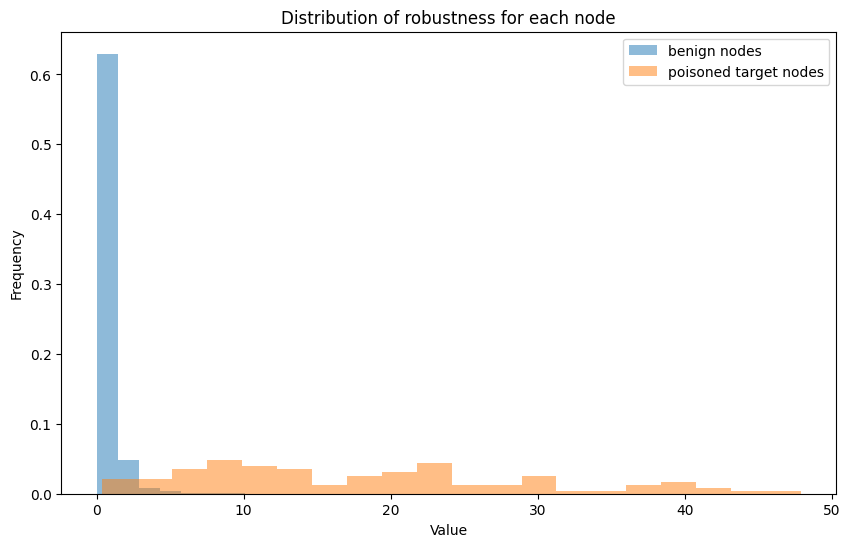

In [45]:


# visualize robustness distribution #
a=torch.mean(summed_deviations,dim=-1)
a_excluding_last_40 = a[:-args.vs_number].detach().cpu()
a_last=a[-mask.sum():].detach().cpu()


a_last_40 = a[-args.vs_number:].detach().cpu()




indices_to_remove = [i for i, node in enumerate(known_nodes[-args.vs_number:]) if data.y[node] == args.target_class]

indices_to_remove = []

a_last_list = list(a_last)

indices_to_check = range(len(known_nodes[-args.vs_number:]))

# indices_to_remove = []

# ##### find those nodes that are already have target class or poisoned failed #####
# for i in indices_to_check:
#     condition1 = data.y[known_nodes[-args.vs_number:][i]] == args.target_class
#     condition2 = output.argmax(dim=1)[idx_attach[i]] != args.target_class
    
#     if condition1 or condition2:
#         indices_to_remove.append(i)

# for index in sorted(indices_to_remove, reverse=True):
#     del a_last_list[index]


a_last_40 = a_last_list
plt.figure(figsize=(10, 6))
# plt.figure(figsize=(40, 24))
##### benign nodes #####
plt.hist(a_excluding_last_40, bins=20, alpha=0.5, label='benign nodes', density=True)
##### poisoned success nodes #####
plt.hist(a_last_40, bins=20, alpha=0.5, label='poisoned target nodes',density=True)
plt.legend(loc='upper right')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of robustness for each node')
plt.savefig('a.jpg')
plt.show()

In [46]:
output_clean[idx_attach].argmax(dim=1)
output_clean = torch.exp(output_clean)

In [47]:
import torch
from torch_geometric.utils import k_hop_subgraph
epsilon = 1e-8

print(output_clean[idx_attach].argmax(dim=1))


from torch_geometric.utils import k_hop_subgraph
result_clean=[]
for node_id in idx_train[:300]:
    node_id = node_id.item()
    subset, edge_index, mapping, edge_mask = k_hop_subgraph(node_id, 2, poison_edge_index, relabel_nodes=False)
    loop_edges = edge_index[:, edge_index[0] == node_id]
    non_loop_edges = edge_index[:, edge_index[0] != node_id]

    selected_x = poison_x[subset]
    
    for i in range(loop_edges.size(1)):
        # Current loop edge to remove
        current_loop_edge = loop_edges[:, i]

        # Find indices of the current loop edge and its reverse
        forward_edge_mask = (edge_index[0] == current_loop_edge[0]) & (edge_index[1] == current_loop_edge[1])
        reverse_edge_mask = (edge_index[0] == current_loop_edge[1]) & (edge_index[1] == current_loop_edge[0])

        # Combine masks for forward and reverse edges
        combined_mask = forward_edge_mask | reverse_edge_mask

        # Remove both forward and reverse edges from the graph
        modified_edge_index = edge_index[:, ~combined_mask]

        edge_weights = torch.ones(modified_edge_index.size(1), dtype=torch.float, device=device)

        output, x = test_model(poison_x, modified_edge_index, edge_weights)
        output = output[node_id]
        output = torch.exp(output)
        output += epsilon
        # print(output)
        # print(output_clean[node_id])
        deviation = F.kl_div(output.log(), output_clean[node_id], reduce=False)
        result_clean.append(deviation.mean().item())
        # print(deviation.mean().item())
print(result_clean)

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2], device='cuda:2')
[0.0003375572559889406, 3.14079225063324e-05, 0.00014035403728485107, 0.0052675469778478146, 0.0004398748278617859, 0.0009955255081877112, 0.0016699049156159163, 0.0009458474814891815, 0.0014372393488883972, 0.0011128647020086646, 0.003506205976009369, 0.00796530582010746, 0.0055937133729457855, 0.001437778351828456, 0.0013884585350751877, 0.001876838505268097, 0.00026164454175159335, 0.0019642352126538754, 0.0018627243116497993, 0.0025472473353147507, 0.0029625201132148504, 0.003079160815104842, 0.0016943620285019279, 0.002394114388152957, 0.0023073290940374136, 0.04716971516609192, 0.01135165523737669, 1.973162170543219e-06, 0.00667211413383

In [48]:
result_trigger = []
for node_id in idx_attach:
    node_id = node_id.item()
    subset, edge_index, mapping, edge_mask = k_hop_subgraph(node_id, 2, poison_edge_index, relabel_nodes=False)
    loop_edges = edge_index[:, edge_index[0] == node_id]
    non_loop_edges = edge_index[:, edge_index[0] != node_id]

    selected_x = poison_x[subset]
    
    for i in range(loop_edges.size(1)):
        # Current loop edge to remove
        current_loop_edge = loop_edges[:, i]

        # Find indices of the current loop edge and its reverse
        forward_edge_mask = (edge_index[0] == current_loop_edge[0]) & (edge_index[1] == current_loop_edge[1])
        reverse_edge_mask = (edge_index[0] == current_loop_edge[1]) & (edge_index[1] == current_loop_edge[0])

        # Combine masks for forward and reverse edges
        combined_mask = forward_edge_mask | reverse_edge_mask

        # Remove both forward and reverse edges from the graph
        modified_edge_index = edge_index[:, ~combined_mask]

        edge_weights = torch.ones(modified_edge_index.size(1), dtype=torch.float, device=device)

        output, x = test_model(poison_x, modified_edge_index, edge_weights)
        output = output[node_id]
        output = torch.exp(output)
        output += epsilon
        # print(output)
        # print(output_clean[node_id])
        deviation = F.kl_div(output.log(), output_clean[node_id], reduce=False)
        
        if loop_edges[:,i][1]>len(data.x):
            # print(loop_edges[:,i][1])
            result_trigger.append(deviation.mean().item())
            
        # else:
        # print(deviation.mean().item())
            # result_clean.append(deviation.mean().item())

        # result_trigger.append(deviation.mean().item())
        # print(deviation.mean().item())
print(result_trigger)

[1.2977380752563477, 0.950320839881897, 0.37811070680618286, 0.07882420718669891, 1.4903225898742676, 0.8596345782279968, 1.0516297817230225, 0.48909837007522583, 0.788267970085144, 0.4453601837158203, 1.1475379467010498, 0.45884519815444946, 1.3244860172271729, 0.9546791911125183, 0.07504454255104065, 0.3208126127719879, 0.8683804273605347, 1.2308802604675293, 0.41911572217941284, 0.309292733669281, 0.6054389476776123, 0.3337344527244568, 0.9251076579093933, 0.9914975166320801, 1.2147763967514038, 1.4215353727340698, 0.047294892370700836, 2.2077574729919434, 1.5065945386886597, 0.45738351345062256, 0.8448051810264587, 1.3847031593322754, 1.9852842092514038, 0.2659023404121399, 2.203679084777832, 1.2907702922821045, 1.3443453311920166, 0.9638511538505554, 1.0708000659942627, 1.1990312337875366, 0.5467737913131714, 0.057270631194114685, 1.3864479064941406, 1.1133534908294678, 0.3127886652946472, 0.8844665288925171, 2.172104597091675, 0.9507893919944763, 0.5689969062805176, 0.74903345108

In [49]:
print(len(result_trigger))
print(min(result_trigger))
print(max(result_trigger))
print(sorted(result_trigger,reverse=True))
print(max(result_clean))
print(sorted(result_clean,reverse=True))

97
0.047294892370700836
3.0774669647216797
[3.0774669647216797, 2.2077574729919434, 2.203679084777832, 2.172104597091675, 2.1706271171569824, 2.095139503479004, 2.0415923595428467, 1.9852842092514038, 1.8749198913574219, 1.6530077457427979, 1.633575201034546, 1.6109274625778198, 1.5065945386886597, 1.4903225898742676, 1.4215353727340698, 1.3864479064941406, 1.3847031593322754, 1.3632395267486572, 1.3443453311920166, 1.3244860172271729, 1.2977380752563477, 1.2907702922821045, 1.2811367511749268, 1.2680003643035889, 1.2578036785125732, 1.2308802604675293, 1.2147763967514038, 1.1990312337875366, 1.1987627744674683, 1.1475379467010498, 1.1469602584838867, 1.1137620210647583, 1.1133534908294678, 1.0979347229003906, 1.0911824703216553, 1.0855787992477417, 1.0708000659942627, 1.0516297817230225, 1.0326588153839111, 1.0092839002609253, 0.9914975166320801, 0.9893349409103394, 0.9662535190582275, 0.9638511538505554, 0.9553132057189941, 0.9546791911125183, 0.9507893919944763, 0.950320839881897, 0

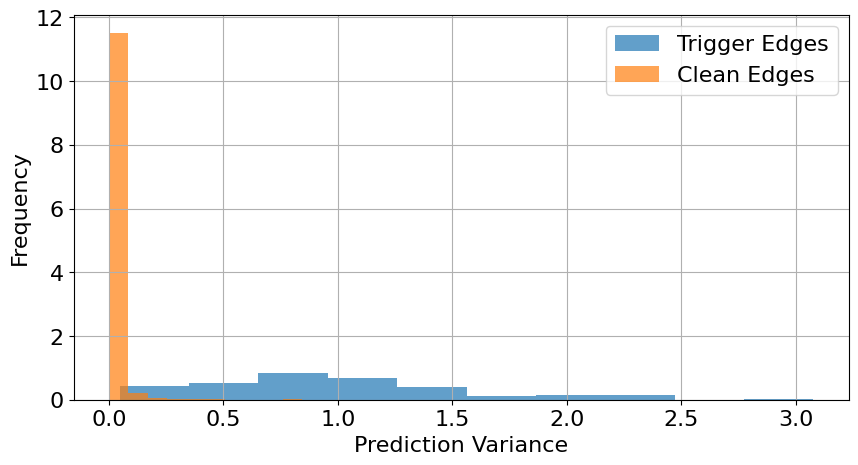

In [50]:
import matplotlib.pyplot as plt

# Ensure you have your data loaded in result_clean and result_trigger
# Example: result_clean = [1, 2, 3], result_trigger = [3, 2, 1]
# result_trigger = [x for x in result_trigger if x < 0.8 and x>0.2]
# result_clean = [x for x in result_clean if x < 2 and x>0.2]

# plt.figure(figsize=(10, 5))

# plt.hist(result_trigger, alpha=0.7, bins=10, label='Trigger Edge',density=True)
# # plt.hist(result_trigger, alpha=0.7, bins=10, label='Trigger Data')

# plt.hist(result_clean, alpha=0.7, bins=10, label='Clean Edge',density=True)
# # plt.hist(result_clean, alpha=0.7, bins=10, label='Clean Data')


# # plt.title('Histogram of Clean and Trigger Data')
# plt.xlabel('Prediction Variance')
# plt.ylabel('Frequency')
# plt.legend()
# plt.grid(True)

# # Save the plot before displaying it
# plt.savefig('cora.pdf')

# # Display the plot
# plt.show()
plt.figure(figsize=(10, 5))

plt.hist(result_trigger, alpha=0.7, bins=10, label='Trigger Edges', density=True)
plt.hist(result_clean, alpha=0.7, bins=10, label='Clean Edges', density=True)

plt.xlabel('Prediction Variance',fontsize=16)
plt.ylabel('Frequency',fontsize=16)

# Adjust x and y ticks
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(fontsize=16)
plt.grid(True)

# Add a caption below the figure
# plt.figtext(0.5, -0.05, 'Comparison of prediction variance due to trigger edges drop and clean edges drop.', wrap=True, horizontalalignment='center', fontsize=14)

# Save the plot before displaying it
plt.savefig('cora.pdf')

# Display the plot
plt.show()

In [51]:
# result_clean=[]
# for node_id in idx_train[:10000]:
#     node_id = node_id.item()
#     subset, edge_index, mapping, edge_mask = k_hop_subgraph(node_id, 2, poison_edge_index, relabel_nodes=False)
#     loop_edges = edge_index[:, edge_index[0] == node_id]
#     non_loop_edges = edge_index[:, edge_index[0] != node_id]

#     selected_x = poison_x[subset]
    
#     for i in range(loop_edges.size(1)):
#         # Current loop edge to remove
#         current_loop_edge = loop_edges[:, i]

#         # Find indices of the current loop edge and its reverse
#         forward_edge_mask = (edge_index[0] == current_loop_edge[0]) & (edge_index[1] == current_loop_edge[1])
#         reverse_edge_mask = (edge_index[0] == current_loop_edge[1]) & (edge_index[1] == current_loop_edge[0])

#         # Combine masks for forward and reverse edges
#         combined_mask = forward_edge_mask | reverse_edge_mask

#         # Remove both forward and reverse edges from the graph
#         modified_edge_index = edge_index[:, ~combined_mask]

#         edge_weights = torch.ones(modified_edge_index.size(1), dtype=torch.float, device=device)

#         output, x = test_model(poison_x, modified_edge_index, edge_weights)
#         output = output[node_id]
#         output = torch.exp(output)
#         output += epsilon
#         deviation = F.kl_div(output.log(), output_clean[node_id], reduce=False)
#         result_clean.append(deviation.mean().item())
#         print(deviation.mean().item())
# print(result_clean)


In [52]:
# result_trigger = []
# for node_id in idx_attach:
#     node_id = node_id.item()
#     subset, edge_index, mapping, edge_mask = k_hop_subgraph(node_id, 2, poison_edge_index, relabel_nodes=False)
#     loop_edges = edge_index[:, edge_index[0] == node_id]
#     non_loop_edges = edge_index[:, edge_index[0] != node_id]

#     selected_x = poison_x[subset]
    
#     for i in range(loop_edges.size(1)):
#         # Current loop edge to remove
#         current_loop_edge = loop_edges[:, i]

#         # Find indices of the current loop edge and its reverse
#         forward_edge_mask = (edge_index[0] == current_loop_edge[0]) & (edge_index[1] == current_loop_edge[1])
#         reverse_edge_mask = (edge_index[0] == current_loop_edge[1]) & (edge_index[1] == current_loop_edge[0])

#         # Combine masks for forward and reverse edges
#         combined_mask = forward_edge_mask | reverse_edge_mask

#         # Remove both forward and reverse edges from the graph
#         modified_edge_index = edge_index[:, ~combined_mask]

#         edge_weights = torch.ones(modified_edge_index.size(1), dtype=torch.float, device=device)

#         output, x = test_model(poison_x, modified_edge_index, edge_weights)
#         output = output[node_id]
#         output = torch.exp(output)
#         output += epsilon
#         deviation = F.kl_div(output.log(), output_clean[node_id], reduce=False)
        
#         if loop_edges[:,i][1]>len(data.x):
#             result_trigger.append(deviation.mean().item())
#         else:
#             print(deviation.mean().item())
#             # result_clean.append(deviation.mean().item())

#         result_trigger.append(deviation.mean().item())
#         print(deviation.mean().item())
# print(result_trigger)


In [53]:
# import matplotlib.pyplot as plt

# # Ensure you have your data loaded in result_clean and result_trigger
# # Example: result_clean = [1, 2, 3], result_trigger = [3, 2, 1]

# plt.figure(figsize=(10, 5))

# plt.hist(result_trigger, alpha=0.7, bins=10, label='Trigger Data',density=True)
# # plt.hist(result_trigger, alpha=0.7, bins=10, label='Trigger Data')

# plt.hist(result_clean, alpha=0.7, bins=10, label='Clean Data',density=True)
# # plt.hist(result_clean, alpha=0.7, bins=10, label='Clean Data')


# plt.title('Histogram of Clean and Trigger Data')
# plt.xlabel('Value')
# plt.ylabel('Frequency')
# plt.legend()
# plt.grid(True)
# plt.show()

In [54]:
poison_labels[idx_attach] = args.target_class

In [55]:
len(idx_attach)

97

In [56]:
## retrain a model on purified graph ##

# labels for target poisoned node before purified #
print(poison_labels[idx_attach])

# purifying #
# for idx in index_of_less_robust:
#     poison_labels[bkd_tn_nodes[idx]]=data.y[bkd_tn_nodes[idx]]
# # poison_labels[idx_attach] = data.y[idx_attach]

# # labels for target poisoned node after purified #
# print(poison_labels[idx_attach])

# retrain a model #s
test_model = model_construct(args,args.test_model,data,device).to(device) 
test_model.fit(poison_x,poison_edge_index, poison_edge_weights, poison_labels, bkd_tn_nodes, idx_val,train_iters=args.epochs,verbose=False, finetune=True, attach=index_of_less_robust)

## test model on purified graph (poisoned target node) ##
clean_acc = test_model.test(poison_x,poison_edge_index, poison_edge_weights,poison_labels,idx_attach)

print("accuracy on clean test nodes: {:.4f}".format(clean_acc))

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2], device='cuda:2')


accuracy on clean test nodes: 0.0000


In [57]:
# add a trigger detector #
# assumption: backdoor attack's success is based on trigger pattern #
# 1. outlier, trigger different to each other #
# 2. in distribution, trigger similar to each other #
# # in case, model trained on clean graph learn attack pattern #
induct_edge_index = torch.cat([poison_edge_index,mask_edge_index],dim=1)
induct_edge_weights = torch.cat([poison_edge_weights,torch.ones([mask_edge_index.shape[1]],dtype=torch.float,device=device)])
induct_x, induct_edge_index,induct_edge_weights = model.inject_trigger(idx_atk,poison_x,induct_edge_index,induct_edge_weights,device)
# induct_x, induct_edge_index,induct_edge_weights = model.inject_trigger(idx_attach,poison_x,induct_edge_index,induct_edge_weights,device)
induct_x, induct_edge_index,induct_edge_weights = induct_x.clone().detach(), induct_edge_index.clone().detach(),induct_edge_weights.clone().detach()

output, x = test_model(induct_x,induct_edge_index,induct_edge_weights)
train_attach_rate = (output.argmax(dim=1)[idx_atk]==args.target_class).float().mean()
# train_attach_rate = (output.argmax(dim=1)[idx_attach]==args.target_class).float().mean()
print("ASR: {:.4f}".format(train_attach_rate))
asr = train_attach_rate
flip_idx_atk = idx_atk[(data.y[idx_atk] != args.target_class).nonzero().flatten()]
flip_asr = (output.argmax(dim=1)[flip_idx_atk]==args.target_class).float().mean()
print("Flip ASR: {:.4f}/{} nodes".format(flip_asr,flip_idx_atk.shape[0]))
ca = test_model.test(induct_x,induct_edge_index,induct_edge_weights,data.y,idx_clean_test)
print("CA: {:.4f}".format(ca))

ASR: 0.0010
Flip ASR: 0.0000/1198 nodes
CA: 0.8387


In [58]:
output.argmax(dim=1)[idx_atk]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [59]:
probs=F.softmax(output[index_of_less_robust], dim=1)
probs

tensor([[3.5123e-02, 1.7231e-02, 9.4765e-01],
        [2.8908e-01, 2.1842e-01, 4.9249e-01],
        [2.5662e-01, 6.6255e-01, 8.0834e-02],
        [1.2321e-02, 9.0827e-01, 7.9408e-02],
        [1.1209e-01, 2.5841e-02, 8.6207e-01],
        [6.6457e-02, 4.9207e-01, 4.4148e-01],
        [9.0467e-01, 4.0869e-02, 5.4457e-02],
        [2.1579e-02, 1.0204e-01, 8.7638e-01],
        [5.3362e-01, 8.7810e-02, 3.7857e-01],
        [9.8310e-01, 5.2436e-03, 1.1656e-02],
        [7.4625e-02, 7.9932e-01, 1.2605e-01],
        [8.4768e-01, 6.9470e-02, 8.2854e-02],
        [6.6169e-01, 2.6795e-02, 3.1151e-01],
        [5.2977e-03, 7.3199e-03, 9.8738e-01],
        [1.2480e-02, 2.6025e-02, 9.6150e-01],
        [3.1993e-01, 3.2073e-01, 3.5935e-01],
        [8.7365e-01, 4.6700e-02, 7.9652e-02],
        [3.2145e-01, 5.4159e-01, 1.3696e-01],
        [5.3858e-01, 5.6415e-02, 4.0500e-01],
        [4.2634e-02, 1.6012e-01, 7.9724e-01],
        [6.0744e-03, 1.3942e-02, 9.7998e-01],
        [1.0885e-01, 1.2842e-02, 8

In [60]:
probs[range(len(poison_labels[index_of_less_robust])), poison_labels[index_of_less_robust]]

tensor([0.9476, 0.2891, 0.6625, 0.9083, 0.8621, 0.4921, 0.9047, 0.8764, 0.5336,
        0.9831, 0.7993, 0.8477, 0.6617, 0.9874, 0.9615, 0.3199, 0.8736, 0.5416,
        0.5386, 0.7972, 0.9800, 0.8783, 0.5664, 0.7607, 0.8103, 0.6441, 0.8939,
        0.8177, 0.9742, 0.2916, 0.3936, 0.2317, 0.3663, 0.9560, 0.2974, 0.6518,
        0.7993, 0.7548, 0.9780, 0.8202, 0.1864, 0.8541, 0.9850, 0.5353, 0.8216,
        0.1955, 0.8383, 0.6561, 0.0646, 0.9822, 0.9740, 0.3314, 0.2967, 0.7816,
        0.9231, 0.8816, 0.8433, 0.8884, 0.8873, 0.3692, 0.9248, 0.9304, 0.7857,
        0.8660, 0.6367, 0.6043, 0.8933, 0.8715, 0.9542, 0.5171, 0.0248, 0.9997,
        0.6605, 0.6716, 0.9985, 0.9937, 0.7377, 0.7477, 0.1959, 0.3584, 0.4964,
        0.9180, 0.9795, 0.6954, 0.9601, 0.6087, 0.1812, 0.8035, 0.8583, 0.9964,
        0.7175, 0.7343, 0.8920, 0.9463, 0.6219, 0.8503, 0.6443],
       device='cuda:2', grad_fn=<IndexBackward0>)

In [61]:
poison_labels[index_of_less_robust]

tensor([2, 0, 1, 1, 2, 1, 0, 2, 0, 0, 1, 0, 0, 2, 2, 0, 0, 1, 0, 2, 2, 2, 1, 0,
        0, 2, 1, 1, 0, 1, 1, 1, 2, 2, 1, 0, 0, 2, 2, 1, 2, 0, 2, 2, 1, 0, 0, 1,
        0, 0, 0, 2, 2, 0, 1, 2, 1, 2, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 0,
        1, 1, 0, 0, 2, 1, 2, 1, 2, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        0], device='cuda:2')